In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [3]:
class Config(object):
    # Root directory for dataset
    dataroot = "/home/alex/Data_Science/HW3/LLD-icon_full_data_PNG/"  
    
    # Number of workers for dataloader
    workers = 2
    
    # Spatial size of training images. All images will be resized to this
    # size using a transformer.
    image_size = 64
    
    # Batch size during training
    batch_size = 128
    
    # Learning rate for optimizers
    lr = 0.0002
    
    # Beta1 hyperparam for Adam optimizers
    beta1 = 0.5
    
    # Number of channels in the training images. For color images this is 3
    nc = 3

    # Size of z latent vector (i.e. size of generator input)
    nz = 100

    # Size of feature maps in generator
    ngf = 64

    # Size of feature maps in discriminator
    ndf = 64
    
    # Number of training epochs
    num_epochs = 50
    
    # Number of GPUs available. Use 0 for CPU mode.
    ngpu = 1
    
opt = Config()

In [4]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=opt.dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(opt.image_size),
                               transforms.CenterCrop(opt.image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt.batch_size,
                                         shuffle=True, num_workers=opt.workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and opt.ngpu > 0) else "cpu")

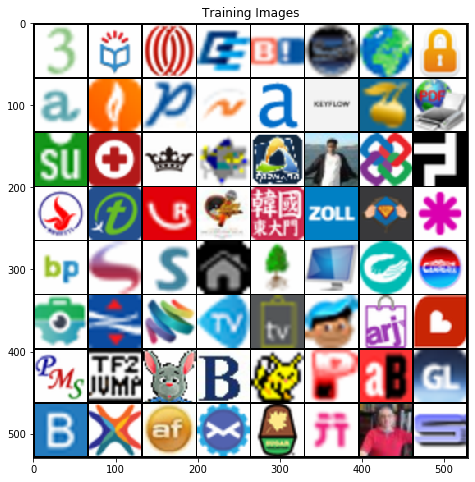

In [5]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("on")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = opt.ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(opt.nz, opt.ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(opt.ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(opt.ngf * 8, opt.ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(opt.ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(opt.ngf * 4, opt.ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(opt.ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(opt.ngf * 2, opt.ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(opt.ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(opt.ngf, opt.nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [8]:
# Create the generator
netG = Generator(opt.ngpu).to(device)

# Handle multi-gpu if desired
#if (device.type == 'cuda') and (ngpu > 1):
#    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [9]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = opt.ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(opt.nc, opt.ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(opt.ndf, opt.ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(opt.ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(opt.ndf * 2, opt.ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(opt.ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(opt.ndf * 4, opt.ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(opt.ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(opt.ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [10]:
# Create the Discriminator
netD = Discriminator(opt.ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (opt.ngpu > 1):
    netD = nn.DataParallel(netD, list(range(opt.ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [11]:
# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))

# Initialize BCELoss function
criterion = nn.BCELoss().to(device)

# Create batch of latent vectors that we will use to visualize
fixed_noise = torch.randn(opt.batch_size, opt.nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0



In [12]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(opt.num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, opt.nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, opt.num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            vutils.save_image(fake.detach(),'/home/alex/Data_Science/HW3/images/process.png',normalize=True)
            if errG.item() <= 1.3:
                vutils.save_image(fake.detach(),'/home/alex/Data_Science/HW3/images/%s_%4f.png' 
                                  % (epoch,errG.item()),normalize=True)
                torch.save(netD.state_dict(), '/home/alex/Data_Science/HW3/checkpoints/netD_%s_%4f.pth ' 
                           % (epoch,errG.item()))
                torch.save(netG.state_dict(), '/home/alex/Data_Science/HW3/checkpoints/netG_%s_%4f.pth ' 
                           % (epoch,errG.item()))
        

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
       

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == opt.num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
            
        iters += 1


Starting Training Loop...
[0/50][0/4283]	Loss_D: 1.8333	Loss_G: 6.3135	D(x): 0.5565	D(G(z)): 0.6043 / 0.0032
[0/50][50/4283]	Loss_D: 0.0523	Loss_G: 15.3723	D(x): 0.9567	D(G(z)): 0.0002 / 0.0000
[0/50][100/4283]	Loss_D: 0.2108	Loss_G: 5.6263	D(x): 0.9248	D(G(z)): 0.0985 / 0.0044
[0/50][150/4283]	Loss_D: 0.1609	Loss_G: 13.2958	D(x): 0.9817	D(G(z)): 0.1272 / 0.0000
[0/50][200/4283]	Loss_D: 0.0443	Loss_G: 6.9626	D(x): 0.9757	D(G(z)): 0.0130 / 0.0011
[0/50][250/4283]	Loss_D: 0.1102	Loss_G: 3.5162	D(x): 0.9352	D(G(z)): 0.0046 / 0.0450
[0/50][300/4283]	Loss_D: 0.7818	Loss_G: 13.7363	D(x): 0.9720	D(G(z)): 0.4588 / 0.0000
[0/50][350/4283]	Loss_D: 0.0611	Loss_G: 8.1061	D(x): 0.9907	D(G(z)): 0.0498 / 0.0004
[0/50][400/4283]	Loss_D: 0.1270	Loss_G: 5.3144	D(x): 0.9118	D(G(z)): 0.0218 / 0.0055
[0/50][450/4283]	Loss_D: 2.6085	Loss_G: 11.7303	D(x): 0.4031	D(G(z)): 0.0001 / 0.0000
[0/50][500/4283]	Loss_D: 0.1266	Loss_G: 3.9877	D(x): 0.9513	D(G(z)): 0.0630 / 0.0244
[0/50][550/4283]	Loss_D: 0.0835	Loss_G

[1/50][500/4283]	Loss_D: 0.6800	Loss_G: 3.4092	D(x): 0.7995	D(G(z)): 0.3257 / 0.0466
[1/50][550/4283]	Loss_D: 0.8993	Loss_G: 2.0717	D(x): 0.5044	D(G(z)): 0.1014 / 0.1789
[1/50][600/4283]	Loss_D: 0.0608	Loss_G: 4.2959	D(x): 0.9587	D(G(z)): 0.0170 / 0.0189
[1/50][650/4283]	Loss_D: 0.3735	Loss_G: 2.9313	D(x): 0.8575	D(G(z)): 0.1682 / 0.0749
[1/50][700/4283]	Loss_D: 0.6051	Loss_G: 2.0171	D(x): 0.6546	D(G(z)): 0.1127 / 0.1715
[1/50][750/4283]	Loss_D: 0.1913	Loss_G: 3.6824	D(x): 0.9545	D(G(z)): 0.1271 / 0.0390
[1/50][800/4283]	Loss_D: 0.0216	Loss_G: 5.1462	D(x): 0.9919	D(G(z)): 0.0132 / 0.0084
[1/50][850/4283]	Loss_D: 0.6868	Loss_G: 2.0632	D(x): 0.6330	D(G(z)): 0.1196 / 0.2051
[1/50][900/4283]	Loss_D: 0.1808	Loss_G: 7.0414	D(x): 0.9958	D(G(z)): 0.1508 / 0.0014
[1/50][950/4283]	Loss_D: 0.8159	Loss_G: 3.0161	D(x): 0.8620	D(G(z)): 0.4268 / 0.0710
[1/50][1000/4283]	Loss_D: 0.0473	Loss_G: 4.0484	D(x): 0.9872	D(G(z)): 0.0333 / 0.0240
[1/50][1050/4283]	Loss_D: 0.0440	Loss_G: 4.4064	D(x): 0.9792	D(G

[2/50][1000/4283]	Loss_D: 0.0117	Loss_G: 5.9335	D(x): 0.9969	D(G(z)): 0.0085 / 0.0040
[2/50][1050/4283]	Loss_D: 0.0121	Loss_G: 5.8756	D(x): 0.9933	D(G(z)): 0.0053 / 0.0045
[2/50][1100/4283]	Loss_D: 0.8689	Loss_G: 4.8829	D(x): 0.9743	D(G(z)): 0.4970 / 0.0207
[2/50][1150/4283]	Loss_D: 0.4413	Loss_G: 4.9659	D(x): 0.9235	D(G(z)): 0.2691 / 0.0113
[2/50][1200/4283]	Loss_D: 0.3858	Loss_G: 1.3390	D(x): 0.7480	D(G(z)): 0.0568 / 0.3324
[2/50][1250/4283]	Loss_D: 0.4349	Loss_G: 2.2111	D(x): 0.7957	D(G(z)): 0.1611 / 0.1445
[2/50][1300/4283]	Loss_D: 0.7952	Loss_G: 1.2676	D(x): 0.6491	D(G(z)): 0.2299 / 0.3396
[2/50][1350/4283]	Loss_D: 0.2738	Loss_G: 3.1657	D(x): 0.8656	D(G(z)): 0.1051 / 0.0637
[2/50][1400/4283]	Loss_D: 0.5275	Loss_G: 2.4459	D(x): 0.7425	D(G(z)): 0.1559 / 0.1244
[2/50][1450/4283]	Loss_D: 0.2049	Loss_G: 3.1748	D(x): 0.9165	D(G(z)): 0.1002 / 0.0589
[2/50][1500/4283]	Loss_D: 0.1804	Loss_G: 3.1927	D(x): 0.8734	D(G(z)): 0.0349 / 0.0619
[2/50][1550/4283]	Loss_D: 3.7806	Loss_G: 0.1705	D(x): 

[3/50][1500/4283]	Loss_D: 0.0279	Loss_G: 4.8987	D(x): 0.9832	D(G(z)): 0.0105 / 0.0122
[3/50][1550/4283]	Loss_D: 4.0463	Loss_G: 2.2169	D(x): 0.1677	D(G(z)): 0.0478 / 0.3876
[3/50][1600/4283]	Loss_D: 0.4524	Loss_G: 2.1632	D(x): 0.7224	D(G(z)): 0.0637 / 0.1701
[3/50][1650/4283]	Loss_D: 0.2411	Loss_G: 2.6850	D(x): 0.8843	D(G(z)): 0.0991 / 0.0972
[3/50][1700/4283]	Loss_D: 1.0410	Loss_G: 2.5275	D(x): 0.4253	D(G(z)): 0.0107 / 0.1325
[3/50][1750/4283]	Loss_D: 0.0270	Loss_G: 4.8203	D(x): 0.9913	D(G(z)): 0.0178 / 0.0116
[3/50][1800/4283]	Loss_D: 0.2392	Loss_G: 4.2734	D(x): 0.9273	D(G(z)): 0.1358 / 0.0271
[3/50][1850/4283]	Loss_D: 0.6080	Loss_G: 0.5185	D(x): 0.6155	D(G(z)): 0.0450 / 0.6525
[3/50][1900/4283]	Loss_D: 0.1887	Loss_G: 4.2216	D(x): 0.9526	D(G(z)): 0.1171 / 0.0224
[3/50][1950/4283]	Loss_D: 0.0791	Loss_G: 4.4212	D(x): 0.9561	D(G(z)): 0.0324 / 0.0168
[3/50][2000/4283]	Loss_D: 2.7812	Loss_G: 9.6690	D(x): 0.9976	D(G(z)): 0.8990 / 0.0001
[3/50][2050/4283]	Loss_D: 0.5871	Loss_G: 1.3566	D(x): 

[4/50][2000/4283]	Loss_D: 0.1614	Loss_G: 4.2041	D(x): 0.9875	D(G(z)): 0.1291 / 0.0233
[4/50][2050/4283]	Loss_D: 0.0442	Loss_G: 4.6344	D(x): 0.9820	D(G(z)): 0.0249 / 0.0158
[4/50][2100/4283]	Loss_D: 0.4584	Loss_G: 1.9444	D(x): 0.6870	D(G(z)): 0.0375 / 0.1979
[4/50][2150/4283]	Loss_D: 0.0152	Loss_G: 5.2688	D(x): 0.9926	D(G(z)): 0.0076 / 0.0077
[4/50][2200/4283]	Loss_D: 0.0163	Loss_G: 5.6148	D(x): 0.9910	D(G(z)): 0.0070 / 0.0071
[4/50][2250/4283]	Loss_D: 0.0049	Loss_G: 6.3477	D(x): 0.9992	D(G(z)): 0.0041 / 0.0032
[4/50][2300/4283]	Loss_D: 0.7316	Loss_G: 3.3101	D(x): 0.9292	D(G(z)): 0.4096 / 0.0708
[4/50][2350/4283]	Loss_D: 0.2295	Loss_G: 3.2394	D(x): 0.9813	D(G(z)): 0.1742 / 0.0563
[4/50][2400/4283]	Loss_D: 0.1061	Loss_G: 4.6936	D(x): 0.9359	D(G(z)): 0.0336 / 0.0146
[4/50][2450/4283]	Loss_D: 1.9585	Loss_G: 0.0541	D(x): 0.2410	D(G(z)): 0.0038 / 0.9500
[4/50][2500/4283]	Loss_D: 0.1172	Loss_G: 4.3177	D(x): 0.9253	D(G(z)): 0.0342 / 0.0211
[4/50][2550/4283]	Loss_D: 0.0622	Loss_G: 4.1895	D(x): 

[5/50][2500/4283]	Loss_D: 0.0070	Loss_G: 6.0759	D(x): 0.9975	D(G(z)): 0.0042 / 0.0036
[5/50][2550/4283]	Loss_D: 0.3844	Loss_G: 2.8507	D(x): 0.8069	D(G(z)): 0.1276 / 0.0890
[5/50][2600/4283]	Loss_D: 0.3119	Loss_G: 3.6457	D(x): 0.8917	D(G(z)): 0.1583 / 0.0413
[5/50][2650/4283]	Loss_D: 0.1424	Loss_G: 3.1574	D(x): 0.9242	D(G(z)): 0.0521 / 0.0636
[5/50][2700/4283]	Loss_D: 0.0521	Loss_G: 4.4820	D(x): 0.9784	D(G(z)): 0.0284 / 0.0184
[5/50][2750/4283]	Loss_D: 0.4080	Loss_G: 6.8871	D(x): 0.9982	D(G(z)): 0.2942 / 0.0015
[5/50][2800/4283]	Loss_D: 0.1383	Loss_G: 3.8343	D(x): 0.8981	D(G(z)): 0.0192 / 0.0363
[5/50][2850/4283]	Loss_D: 0.0532	Loss_G: 4.3710	D(x): 0.9782	D(G(z)): 0.0276 / 0.0202
[5/50][2900/4283]	Loss_D: 0.0729	Loss_G: 4.1739	D(x): 0.9431	D(G(z)): 0.0113 / 0.0292
[5/50][2950/4283]	Loss_D: 0.4710	Loss_G: 2.6506	D(x): 0.7013	D(G(z)): 0.0436 / 0.1156
[5/50][3000/4283]	Loss_D: 0.1233	Loss_G: 3.9357	D(x): 0.9553	D(G(z)): 0.0706 / 0.0342
[5/50][3050/4283]	Loss_D: 0.0497	Loss_G: 4.7108	D(x): 

[6/50][3000/4283]	Loss_D: 0.0111	Loss_G: 5.9715	D(x): 0.9954	D(G(z)): 0.0064 / 0.0048
[6/50][3050/4283]	Loss_D: 0.8208	Loss_G: 1.7331	D(x): 0.5537	D(G(z)): 0.0579 / 0.2621
[6/50][3100/4283]	Loss_D: 0.4683	Loss_G: 3.8351	D(x): 0.9391	D(G(z)): 0.2895 / 0.0334
[6/50][3150/4283]	Loss_D: 0.1518	Loss_G: 4.2334	D(x): 0.8840	D(G(z)): 0.0130 / 0.0256
[6/50][3200/4283]	Loss_D: 2.4532	Loss_G: 8.4604	D(x): 0.9993	D(G(z)): 0.8383 / 0.0007
[6/50][3250/4283]	Loss_D: 0.1495	Loss_G: 4.9949	D(x): 0.9884	D(G(z)): 0.1212 / 0.0118
[6/50][3300/4283]	Loss_D: 0.0474	Loss_G: 4.6697	D(x): 0.9735	D(G(z)): 0.0188 / 0.0182
[6/50][3350/4283]	Loss_D: 0.0403	Loss_G: 5.6341	D(x): 0.9667	D(G(z)): 0.0055 / 0.0072
[6/50][3400/4283]	Loss_D: 0.0192	Loss_G: 5.5446	D(x): 0.9927	D(G(z)): 0.0117 / 0.0062
[6/50][3450/4283]	Loss_D: 1.4401	Loss_G: 4.7175	D(x): 0.9731	D(G(z)): 0.5794 / 0.0429
[6/50][3500/4283]	Loss_D: 0.2375	Loss_G: 3.4703	D(x): 0.8817	D(G(z)): 0.0848 / 0.0496
[6/50][3550/4283]	Loss_D: 0.1354	Loss_G: 4.5594	D(x): 

[7/50][3500/4283]	Loss_D: 0.2695	Loss_G: 3.2846	D(x): 0.8990	D(G(z)): 0.1292 / 0.0630
[7/50][3550/4283]	Loss_D: 0.2055	Loss_G: 3.0100	D(x): 0.8393	D(G(z)): 0.0043 / 0.0900
[7/50][3600/4283]	Loss_D: 0.0451	Loss_G: 5.6383	D(x): 0.9626	D(G(z)): 0.0058 / 0.0080
[7/50][3650/4283]	Loss_D: 0.0792	Loss_G: 3.5445	D(x): 0.9363	D(G(z)): 0.0102 / 0.0490
[7/50][3700/4283]	Loss_D: 0.0055	Loss_G: 6.4265	D(x): 0.9993	D(G(z)): 0.0048 / 0.0033
[7/50][3750/4283]	Loss_D: 0.0121	Loss_G: 5.8980	D(x): 0.9976	D(G(z)): 0.0096 / 0.0049
[7/50][3800/4283]	Loss_D: 0.0218	Loss_G: 5.2117	D(x): 0.9983	D(G(z)): 0.0196 / 0.0096
[7/50][3850/4283]	Loss_D: 0.3176	Loss_G: 2.8770	D(x): 0.9663	D(G(z)): 0.2177 / 0.0892
[7/50][3900/4283]	Loss_D: 0.1147	Loss_G: 4.4678	D(x): 0.9906	D(G(z)): 0.0926 / 0.0205
[7/50][3950/4283]	Loss_D: 0.0608	Loss_G: 5.1092	D(x): 0.9526	D(G(z)): 0.0078 / 0.0131
[7/50][4000/4283]	Loss_D: 0.8928	Loss_G: 11.2518	D(x): 0.9973	D(G(z)): 0.4888 / 0.0000
[7/50][4050/4283]	Loss_D: 0.0850	Loss_G: 4.7681	D(x):

[8/50][4000/4283]	Loss_D: 0.0727	Loss_G: 5.2913	D(x): 0.9838	D(G(z)): 0.0524 / 0.0104
[8/50][4050/4283]	Loss_D: 0.4190	Loss_G: 6.7131	D(x): 0.9900	D(G(z)): 0.2787 / 0.0025
[8/50][4100/4283]	Loss_D: 0.0468	Loss_G: 4.3913	D(x): 0.9724	D(G(z)): 0.0176 / 0.0224
[8/50][4150/4283]	Loss_D: 0.0418	Loss_G: 5.3852	D(x): 0.9960	D(G(z)): 0.0337 / 0.0081
[8/50][4200/4283]	Loss_D: 0.0266	Loss_G: 5.3904	D(x): 0.9985	D(G(z)): 0.0244 / 0.0086
[8/50][4250/4283]	Loss_D: 0.1607	Loss_G: 4.2467	D(x): 0.8955	D(G(z)): 0.0372 / 0.0319
[9/50][0/4283]	Loss_D: 0.1111	Loss_G: 4.9309	D(x): 0.9776	D(G(z)): 0.0790 / 0.0127
[9/50][50/4283]	Loss_D: 0.0282	Loss_G: 6.4502	D(x): 0.9755	D(G(z)): 0.0012 / 0.0030
[9/50][100/4283]	Loss_D: 0.0060	Loss_G: 6.5253	D(x): 0.9972	D(G(z)): 0.0033 / 0.0030
[9/50][150/4283]	Loss_D: 0.0093	Loss_G: 8.9498	D(x): 0.9911	D(G(z)): 0.0002 / 0.0003
[9/50][200/4283]	Loss_D: 0.0061	Loss_G: 7.2609	D(x): 0.9951	D(G(z)): 0.0012 / 0.0016
[9/50][250/4283]	Loss_D: 0.0091	Loss_G: 6.5865	D(x): 0.9939	D(

[10/50][200/4283]	Loss_D: 0.0187	Loss_G: 6.0229	D(x): 0.9945	D(G(z)): 0.0129 / 0.0053
[10/50][250/4283]	Loss_D: 0.0048	Loss_G: 7.3569	D(x): 0.9967	D(G(z)): 0.0015 / 0.0015
[10/50][300/4283]	Loss_D: 0.0168	Loss_G: 6.1835	D(x): 0.9989	D(G(z)): 0.0148 / 0.0058
[10/50][350/4283]	Loss_D: 0.0015	Loss_G: 7.0048	D(x): 0.9997	D(G(z)): 0.0012 / 0.0018
[10/50][400/4283]	Loss_D: 0.2388	Loss_G: 4.1703	D(x): 0.9333	D(G(z)): 0.1283 / 0.0404
[10/50][450/4283]	Loss_D: 0.2501	Loss_G: 5.4492	D(x): 0.8265	D(G(z)): 0.0168 / 0.0125
[10/50][500/4283]	Loss_D: 0.0810	Loss_G: 4.7202	D(x): 0.9952	D(G(z)): 0.0684 / 0.0159
[10/50][550/4283]	Loss_D: 0.0268	Loss_G: 5.4686	D(x): 0.9797	D(G(z)): 0.0057 / 0.0081
[10/50][600/4283]	Loss_D: 0.0032	Loss_G: 7.6882	D(x): 0.9980	D(G(z)): 0.0012 / 0.0012
[10/50][650/4283]	Loss_D: 0.0095	Loss_G: 5.7159	D(x): 0.9960	D(G(z)): 0.0055 / 0.0061
[10/50][700/4283]	Loss_D: 0.2427	Loss_G: 4.0099	D(x): 0.9933	D(G(z)): 0.1678 / 0.0383
[10/50][750/4283]	Loss_D: 0.0861	Loss_G: 3.9267	D(x): 

[11/50][650/4283]	Loss_D: 0.1466	Loss_G: 4.5387	D(x): 0.9658	D(G(z)): 0.0819 / 0.0217
[11/50][700/4283]	Loss_D: 0.0704	Loss_G: 5.8371	D(x): 0.9490	D(G(z)): 0.0127 / 0.0077
[11/50][750/4283]	Loss_D: 0.9956	Loss_G: 1.9108	D(x): 0.5525	D(G(z)): 0.0460 / 0.2741
[11/50][800/4283]	Loss_D: 0.0809	Loss_G: 4.3494	D(x): 0.9437	D(G(z)): 0.0165 / 0.0258
[11/50][850/4283]	Loss_D: 0.0426	Loss_G: 6.0416	D(x): 0.9713	D(G(z)): 0.0103 / 0.0064
[11/50][900/4283]	Loss_D: 0.0322	Loss_G: 5.5467	D(x): 0.9808	D(G(z)): 0.0119 / 0.0082
[11/50][950/4283]	Loss_D: 0.0288	Loss_G: 5.3457	D(x): 0.9922	D(G(z)): 0.0204 / 0.0091
[11/50][1000/4283]	Loss_D: 0.0063	Loss_G: 6.6262	D(x): 0.9970	D(G(z)): 0.0032 / 0.0028
[11/50][1050/4283]	Loss_D: 4.8192	Loss_G: 0.4536	D(x): 0.0339	D(G(z)): 0.0000 / 0.7204
[11/50][1100/4283]	Loss_D: 0.1127	Loss_G: 4.4453	D(x): 0.9901	D(G(z)): 0.0870 / 0.0226
[11/50][1150/4283]	Loss_D: 0.0164	Loss_G: 5.8101	D(x): 0.9926	D(G(z)): 0.0087 / 0.0073
[11/50][1200/4283]	Loss_D: 0.0095	Loss_G: 6.7664	D

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()